In [2]:
# convert data
import os
import numpy as np
import pickle as pkl
import torch
from torchvision.utils import save_image

file_header = 'csci-ua-473-intro-to-machine-learning-fall-2022'
trainx = torch.load(file_header + '/train/train/trainX.pt')
trainy = torch.load(file_header + '/train/train/trainY.pt')
testx = torch.load(file_header + '/test/test/testX.pt')

num_train = trainx[0].shape[0]
num_test = testx[0].shape[0]

os.makedirs('./lazydata', exist_ok=True)

# Save train data
os.makedirs('./lazydata/train', exist_ok=True)
os.makedirs('./lazydata/train/X', exist_ok=True)
os.makedirs('./lazydata/train/Y', exist_ok=True)
for i in range(num_train):
    os.makedirs('./lazydata/train/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/train/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(trainx[0][i][j]/255, './lazydata/train/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = trainx[1][i].numpy()
    np.save('./lazydata/train/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(trainx[2][i], open('./lazydata/train/X/{}/field_id.pkl'.format(i), 'wb'))

    y = trainy[0][i].numpy()
    np.save('./lazydata/train/Y/{}.npy'.format(i), y)
print("Saved train data")

# Save test data
os.makedirs('./lazydata/test', exist_ok=True)
os.makedirs('./lazydata/test/X', exist_ok=True)
for i in range(num_test):
    os.makedirs('./lazydata/test/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/test/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(testx[0][i][j]/255, './lazydata/test/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = testx[1][i].numpy()
    np.save('./lazydata/test/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(testx[2][i], open('./lazydata/test/X/{}/field_id.pkl'.format(i), 'wb'))

print("Saved test data")

Saved train data
Saved test data


In [1]:
import cv2
import os
import torch
import pickle as pkl
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.optim as optim

In [2]:
# lazy loading data
class LazyLoadDataset(Dataset):
    def __init__(self, path, train = True, transform = None):
        self.transform = transform
        self.train = train
        path = path + ('train/' if train else 'test/')

        self.pathX = path + 'X/'
        self.pathY = path + 'Y/'

        self.data = os.listdir(self.pathX)
    
    def __getitem__(self, index):
        f = self.data[index]

        # X
        # read rgb images
        img0 = cv2.imread(self.pathX + f + '/rgb/0.png')
        img1 = cv2.imread(self.pathX + f + '/rgb/1.png')
        img2 = cv2.imread(self.pathX + f + '/rgb/2.png')

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        # read depth
        depth = np.load(self.pathX + f + '/depth.npy') / 1000

        #read field id
        field_id = pkl.load(open(self.pathX + f + '/field_id.pkl', 'rb'))

        # Y
        if self.train:
            Y = np.load(self.pathY + f + '.npy')

            return (img0, img1, img2, depth, field_id), Y
        else:
            return (img0, img1, img2, depth, field_id)
        
    def __len__(self):
        return len(self.data)

In [3]:
# Normalize the data  
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = LazyLoadDataset('./lazydata/', transform = transform)

# split the train dataset to create test dataset
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# test_dataset = LazyLoadDataset('./lazydata/', train = False, transform = transform)
test_dataloader = DataLoader(test_dataset, batch_size=64 * 2, shuffle=True)

In [303]:
# depth.shape

In [304]:
# Y.shape

(3, 224, 224)


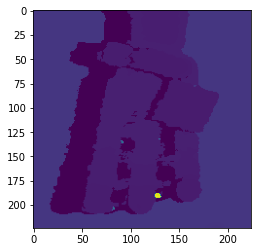

In [202]:
# train_dataset = LazyLoadDataset('./lazydata/')
# (img0, img1, img2, depth, field_id), Y = train_dataset[0]
# print(depth.shape)

# import matplotlib.pyplot as plt
# plt.imshow(img0.squeeze())
# plt.imshow(depth[0])
# plt.show()

torch.Size([3, 224, 224])


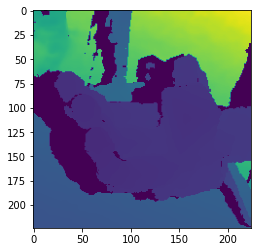

In [209]:
import matplotlib.pyplot as plt

for (img0, img1, img2, depth, field_id), Y in train_dataloader:
    print(depth[1].squeeze().shape)
    # print(img0[0].squeeze().shape)
    # plt.imshow(img2[20].squeeze().permute(1, 2, 0))
    plt.imshow(depth[0][2].squeeze())
    plt.show()
    break

plt.show()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train with CNN
Define a convolutional neural network with the following architecture.

```
Conv(
    conv2D(input_size, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
    conv2d(conv_feature, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
)

FC(
    linear_feature(conv_feature*4*4, fc_feature),
    relu(),
    linear_feature(fc_feature, output_size),
    log_softmax()
)
```

In [192]:
# AlexNet architecture
class CNN(nn.Module):
    def __init__(self, input_channels, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, conv_feature, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(conv_feature, conv_feature, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(conv_feature, conv_feature, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(conv_feature, conv_feature, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(conv_feature, conv_feature, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv_feature * 6 * 6, fc_feature)
        self.fc2 = nn.Linear(fc_feature, fc_feature)
        self.fc3 = nn.Linear(fc_feature, output_size)
        # self.conv1 = nn.Conv2d(input_channels, conv_feature, kernel_size = 5)
        # self.conv2 = nn.Conv2d(conv_feature, conv_feature, kernel_size = 5)
        # self.relu = nn.ReLU()
        # self.maxpool = nn.MaxPool2d(2)
        # self.flatten = nn.Flatten()
        # self.linear1 = nn.Linear(conv_feature*4*4, fc_feature)
        # self.linear2 = nn.Linear(fc_feature, output_size)
        
    def forward(self, x):
        # print(x.shape)
        x = self.relu(self.conv1(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.relu(self.conv3(x))
        # print(x.shape)
        x = self.relu(self.conv4(x))
        # print(x.shape)
        x = self.relu(self.conv5(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        # print(x.shape)
        x = self.relu(self.fc2(x))
        # print(x.shape)
        x = self.fc3(x)
        # print(x.shape)
        # x = self.log_softmax(x)
        return x

In [5]:
# AlexNet architecture
class CNN(nn.Module):
    def __init__(self, input_channels, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(12, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(conv_feature * 6 * 6, fc_feature)
        self.fc2 = nn.Linear(fc_feature, fc_feature)
        self.fc3 = nn.Linear(fc_feature, output_size)
        
    def forward(self, x):
        # print(x.shape)
        x = self.relu(self.conv1(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.relu(self.conv3(x))
        # print(x.shape)
        x = self.relu(self.conv4(x))
        # print(x.shape)
        x = self.relu(self.conv5(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.avgpool(x)
        x = self.flatten(x)
        # print(x.shape)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        # print(x.shape)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        # print(x.shape)
        x = self.fc3(x)
        # print(x.shape)
        # x = self.log_softmax(x)
        return x

In [123]:
# another simple architecture
class CNN(nn.Module):
    def __init__(self, input_channels, conv_features, fc_features, output_size):
        super().__init__()
        # initial size is (3, 224, 224)
        self.conv1 = nn.Conv2d(9, 64, kernel_size=11, stride=4, padding=0)
        self.conv2 = nn.Conv2d(64, 96, kernel_size=5, padding=0)
        self.conv3 = nn.Conv2d(96, 64, kernel_size=3, padding=0)


        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(1024, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 12)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        # print(x.shape)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x
        

In [6]:
def train(epoch, model, optimizer):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx, ((img0, img1, img2, depth, field_id), target) in enumerate(train_dataloader):
        # send three images to device
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        # send target to device
        target = target.to(device)
        # data, target = img0.to(device), target.to(device)
        # print (data.shape)

        optimizer.zero_grad()
        output = model(data)
        # normalize target
        # target = nn.functional.normalize(target, dim=1)

        loss = nn.MSELoss()(output.float(), target.float() * 1000.0)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_dataloader.dataset),
            100. * batch_idx / len(train_dataloader), loss.item()))

In [7]:
# test the model
def test(model):
    model.eval()
    test_loss = 0

    for batch_idx, ((img0, img1, img2, depth, field_id), target) in enumerate(test_dataloader):
        # send three images to device
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        target = target.to(device)

        pred = model(data)

        rmse = torch.sqrt(nn.MSELoss()(pred.float(), target.float() * 1000.0))
        test_loss += rmse.item()

    test_loss /= len(test_dataloader.dataset)
    print('Test set: Average RMSE: {:.5f}'.format(test_loss))

        
    

In [8]:
# Training settings 
# number of feature maps
conv_features = 256
# number of input channels
input_channels = 3
fc_features = 4096
output_size = 12

model_cnn = CNN(input_channels, conv_features, fc_features, output_size) # create CNN model
model_cnn.to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0001) # create optimizer
# optimizer = optim.SGD(params = model_cnn.parameters(), lr = 0.01, momentum = 0.5) # use SGD with learning rate 0.01 and momentum 0.5
# print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 15):
    train(epoch, model_cnn, optimizer)
    test(model_cnn)

Train Epoch: 0 [0/2716 (0%)]	Loss: 4459.132812
Train Epoch: 0 [640/2716 (23%)]	Loss: 2679.030273
Train Epoch: 0 [1280/2716 (47%)]	Loss: 637.881470
Train Epoch: 0 [1920/2716 (70%)]	Loss: 615.464050
Train Epoch: 0 [2560/2716 (93%)]	Loss: 641.709961
Test set: Average RMSE: 0.21749
Train Epoch: 1 [0/2716 (0%)]	Loss: 657.993774
Train Epoch: 1 [640/2716 (23%)]	Loss: 547.295166
Train Epoch: 1 [1280/2716 (47%)]	Loss: 544.764648
Train Epoch: 1 [1920/2716 (70%)]	Loss: 565.400757
Train Epoch: 1 [2560/2716 (93%)]	Loss: 574.359802
Test set: Average RMSE: 0.21454
Train Epoch: 2 [0/2716 (0%)]	Loss: 495.497498
Train Epoch: 2 [640/2716 (23%)]	Loss: 538.238708
Train Epoch: 2 [1280/2716 (47%)]	Loss: 561.878601
Train Epoch: 2 [1920/2716 (70%)]	Loss: 513.913696
Train Epoch: 2 [2560/2716 (93%)]	Loss: 611.565857
Test set: Average RMSE: 0.21175
Train Epoch: 3 [0/2716 (0%)]	Loss: 550.610352
Train Epoch: 3 [640/2716 (23%)]	Loss: 551.695435
Train Epoch: 3 [1280/2716 (47%)]	Loss: 443.240906
Train Epoch: 3 [1920/2

In [9]:
test(model_cnn)

Test set: Average RMSE: 0.08585


In [13]:
test_dataset = LazyLoadDataset('./lazydata/', train = False, transform = transform)
test_dataloader = DataLoader(test_dataset, batch_size=64 * 2, shuffle=True)

In [11]:
# predict
def predict(model):
    model.eval()
    pred = []
    for i, ((img0, img1, img2, depth, field_id)) in enumerate(test_dataloader):
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        output = model(data)
        # print(output)
        pred.append(output.cpu().detach().numpy())
    return np.concatenate(pred) / 1000.0

In [12]:
predict(model_cnn)

array([[ 0.04260449,  0.05248722,  0.12111972, ...,  0.06276813,
         0.04001951, -0.02848843],
       [ 0.04068422,  0.05299736,  0.12302349, ...,  0.05628278,
         0.04374341, -0.02920469],
       [ 0.05611328,  0.04687389,  0.09905244, ...,  0.04615065,
         0.03231372, -0.03750097],
       ...,
       [ 0.03295758,  0.0542848 ,  0.130284  , ...,  0.0511679 ,
         0.01688966, -0.06481688],
       [ 0.04262938,  0.05238463,  0.12117314, ...,  0.06568577,
         0.0282242 , -0.04039713],
       [ 0.04030341,  0.05229302,  0.12252476, ...,  0.04434344,
         0.04923514, -0.03103393]], dtype=float32)

In [14]:
import pandas as pd

def predict(model):
    outfile = 'submission.csv'
    output_file = open(outfile, 'w')
    titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
    
    model.eval()
    pred = []
    file_ids = []

    for i, ((img0, img1, img2, depth, field_id)) in enumerate(test_dataloader):
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        output = model(data)
        print(output)
        # output = output.cpu().detach().numpy()
        pred.append(output.cpu().detach().numpy())
        file_ids.extend(field_id)
        # file_ids = np.array(field_id)
    
    pred = np.concatenate(pred) / 1000.0
    print(pred)
    # pred = pred.flatten()
    # print('t1: ' + np.array(pred).shape)
    # print(np.array(field_id).shape)

    # pred = np.array(pred)
    df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(pred)], axis = 1, names = titles)
    df.columns = titles
    df.to_csv(outfile, index = False)
    print("Written to csv file {}".format(outfile))

In [15]:
predict(model_cnn)

tensor([[ 35.3639,  52.3125, 124.3593,  ...,  47.9269,  33.0653, -47.7930],
        [ 55.3949,  48.2136, 103.9813,  ...,  54.5321,  22.2653, -47.0412],
        [ 51.1866,  51.7722, 115.7034,  ...,  57.4950,  39.9146, -32.6872],
        ...,
        [ 56.2190,  51.6550, 112.6962,  ...,  42.9639,  63.8536, -14.0271],
        [ 58.6196,  50.3177, 107.5032,  ...,  46.2227,  36.9391, -36.4901],
        [ 47.2815,  50.4974, 114.1115,  ...,  59.6881,  47.2448, -16.1998]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 43.6833,  50.4404, 115.1625,  ...,  52.5550,  13.0903, -59.1864],
        [ 41.6919,  52.8279, 122.4487,  ...,  55.7062,  35.9003, -37.5766],
        [ 44.7941,  51.5935, 117.9443,  ...,  60.5733,  39.1368, -28.2921],
        ...,
        [ 50.6600,  52.0727, 116.2784,  ...,  55.6236,  52.7502, -20.6041],
        [ 49.7934,  52.0326, 117.7399,  ...,  44.5177,  45.1442, -34.3692],
        [ 37.9813,  52.7555, 124.4596,  ...,  49.7976,  17.1625, -61.5768]],
       dev